# Clean Census ZCTA Shapefiles

This notebook filters ZCTA shapefiles to the Phoenix metro area, which is Maricopa and Pinal counties

## Data Sources

2020 Zip Code Tabulation Area shapefile (national): https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
<br>
<br>
HUD crosswalk data ZIP-COUNTY: https://www.huduser.gov/portal/datasets/usps_crosswalk.html
<br>
<br>
Section 8 vouchers by zip code (metro Phoenix): Requested from seven public housing authorities. Data is as of April 1, 2022.
<ul>
    <li>Maricopa County</li>
    <li>Phoenix</li>
    <li>Mesa</li>
    <li>Glendale</li>
    <li>Scottsdale</li>
    <li>Tempe</li>
    <li>Chandler (does not have vouchers by zipcode)</li>
</ul>
Census demographic data by ZCTA for AZ:
<ul>
    <li>B17020 Poverty Status in the Past 12 Months by Age</li>
    <li>B19013 Median Household Income in the Past 12 Months</li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib

### Load shapefile data

In [4]:
zipfile = '/Users/amyqin/Documents/data/source/tl_2021_us_zcta520.zip'

In [5]:
zctas = gpd.read_file(zipfile)

In [6]:
#insepct loaded data
zctas.head()

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,47236,47236,B5,G6350,S,1029067,0,+39.1517426,-085.7252769,"POLYGON ((-85.73410 39.15597, -85.72749 39.156..."
1,47870,47870,B5,G6350,S,8830,0,+39.3701518,-087.4735141,"POLYGON ((-87.47414 39.37016, -87.47409 39.370..."
2,47851,47851,B5,G6350,S,53547,0,+39.5735818,-087.2459626,"POLYGON ((-87.24770 39.57431, -87.24770 39.574..."
3,47337,47337,B5,G6350,S,303089,0,+39.8027537,-085.4372850,"POLYGON ((-85.44357 39.80328, -85.44346 39.803..."
4,47435,47435,B5,G6350,S,13302,0,+39.2657557,-086.2951577,"POLYGON ((-86.29592 39.26547, -86.29592 39.266..."


<AxesSubplot:>

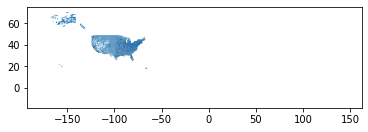

In [16]:
zctas.plot()

In [13]:
#check projection
zctas.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### Load HUD data

Load and filter for only metro Phoenix, which is Maricopa county = 04013 and Pinal county = 04021

In [7]:
hud = pd.read_excel('/Users/amyqin/Documents/data/source/ZIP_COUNTY_122021.xlsx')

In [8]:
hud.head()

,zip,county,usps_zip_pref_city,usps_zip_pref_state,res_ratio,bus_ratio,oth_ratio,tot_ratio
0,683,72125,SAN GERMAN,PR,0.953036,0.996656,0.980769,0.956300
1,683,72079,SAN GERMAN,PR,0.000949,0.000000,0.000000,0.000873
2,683,72023,SAN GERMAN,PR,0.000791,0.001115,0.000000,0.000800
3,683,72097,SAN GERMAN,PR,0.000158,0.000000,0.000000,0.000145
4,683,72121,SAN GERMAN,PR,0.045066,0.002230,0.019231,0.041882


In [9]:
metrophx_zips = hud.query('county == 4013 or county == 4021')

### Load voucher data

Note about data: zip codes that appear multiple times means those zip codes are in more than one PHA.

In [77]:
vouchers = pd.read_csv('/Users/amyqin/Documents/data/processed/vouchers.csv')

In [78]:
vouchers.head()

,Zip code,PHA,Number of vouchers
0,85301,Glendale,620
1,85041,Phoenix,568
2,85015,Phoenix,463
3,85201,Mesa,429
4,85008,Phoenix,418


In [79]:
vouchers.groupby('PHA')['Number of vouchers'].sum()

PHA
Glendale           1194
Maricopa County    1324
Mesa               1446
Phoenix            6152
Scottsdale          569
Tempe               870
mesa                241
Name: Number of vouchers, dtype: int64

### Load Census data and merge with voucher data

In [72]:
#percent below poverty 
below_poverty = pd.read_csv('/Users/amyqin/Documents/data/processed/percent_below_poverty_AZ_ZCTA_2020_census/ACSDT5Y2020.B17020_data_with_overlays_2022-06-13T200643.csv',
                           skiprows = 1)

#median income
median_income = pd.read_csv('/Users/amyqin/Documents/data/processed/median_household_income_ZCTA_AZ_2020_census/ACSDT5Y2020.B19013_data_with_overlays_2022-04-26T202138.csv',
                            skiprows = 1)

In [73]:
#calculate percent below poverty by zip
below_poverty['pct_below_poverty'] = below_poverty['Estimate!!Total:!!Income in the past 12 months below poverty level:']/below_poverty['Estimate!!Total:']

In [74]:
#clean up dataframes

#create a list of column numbers to drop for below_poverty
cols = list(range(0,36))

#drop all irrelevant columns
below_poverty.drop(below_poverty.columns[cols],axis=1,inplace=True)

#clean up income dataframe
cols = [1,2,3]
median_income.drop(median_income.columns[cols],axis=1,inplace=True)

#rename median income column
median_income.rename(columns={'Estimate!!Median household income in the past 12 months (in 2020 inflation-adjusted dollars)':'median_income'}, inplace=True)

In [80]:
#make merges on zipcode
vouchers = pd.merge(vouchers,below_poverty[['ZIPCODE','pct_below_poverty']],left_on='Zip code',right_on='ZIPCODE')
vouchers = pd.merge(vouchers,median_income[['ZIPCODE','median_income']],left_on='Zip code',right_on='ZIPCODE')

In [83]:
del vouchers['ZIPCODE_x']
del vouchers['ZIPCODE_y']

In [84]:
vouchers.head()

,Zip code,PHA,Number of vouchers,pct_below_poverty,median_income
0,85301,Glendale,620,0.311492,38454
1,85301,Maricopa County,1,0.311492,38454
2,85041,Phoenix,568,0.162583,58438
3,85015,Phoenix,463,0.278371,42038
4,85201,Mesa,429,0.198162,46348
